# Concevez une application au service de la santé publique

## Nettoyage du jeu de données

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('missingno version : ', msno.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')
print('sklearn version : ', sklearn.__version__, '\n')

pandas version :  1.2.4 

numpy version :  1.20.1 

missingno version :  0.5.0 

matplotlib version :  3.3.4 

seaborn version :  0.11.2 

sklearn version :  0.24.1 



Nous allons nous intéresser seulement à certaines colonnes du jeu de données fourni par OpenFoodFacts.  Nous allons nous concentrer sur les produits vendus en France et sur les valeurs nutritionnelles de ces produits qui entrent dans le calcul de leur Nutriscore (teneur énergétique, protéine, teneur en fruits et légumes, sucre, gras saturés, fibre et sodium). Nous allons aussi garder des colonnes qui permettent d'obtenir des informations supplémentaires sur le produit (code barre, catégorie de produit, présence ou non d'additifs et d'huile de palme, photos des produits).

In [3]:
liste_colonnes = ['created_datetime','product_name', 'generic_name', 'code',\
                  'pnns_groups_2', 'countries', 'countries_tags',\
                  'additives_n', 'additives_tags', 'ingredients_from_palm_oil_n',\
                  'ingredients_from_palm_oil_tags','ingredients_that_may_be_from_palm_oil_n',\
                  'ingredients_that_may_be_from_palm_oil_tags', 'image_url',\
                  'image_small_url', 'energy_100g', 'energy-kj_100g',\
                  'energy-kcal_100g', 'proteins_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g',\
                  'sodium_100g', 'fruits-vegetables-nuts_100g',\
                  'fruits-vegetables-nuts-estimate-from-ingredients_100g',\
                  'nutrition-score-fr_100g', 'nutriscore_score', 'nutriscore_grade']

In [4]:
data = pd.read_csv('en.openfoodfacts.org.products.csv', sep = '\t', iterator = True, low_memory = False,\
                   usecols = liste_colonnes, chunksize = 100000)

df = pd.concat(data, ignore_index = True)

In [5]:
#Regardons la taille de notre jeu de données
df.shape

(2017243, 28)

Vérifions s'il y a des doublons.

In [6]:
df.duplicated().sum()

6

In [7]:
df.drop_duplicates(inplace = True)

In [8]:
df.shape

(2017237, 28)

In [9]:
print(df.isnull().sum(), '\n')
print(df.isnull().mean())

code                                                           0
created_datetime                                               0
product_name                                               82508
generic_name                                             1895763
countries                                                   6139
countries_tags                                              6144
additives_n                                              1290321
additives_tags                                           1598237
ingredients_from_palm_oil_n                              1290321
ingredients_from_palm_oil_tags                           2002719
ingredients_that_may_be_from_palm_oil_n                  1290321
ingredients_that_may_be_from_palm_oil_tags               1974200
nutriscore_score                                         1292959
nutriscore_grade                                         1292959
pnns_groups_2                                                119
image_url                

Il y a énormément de valeurs manquantes dans notre DataFrame, certaines colonnes sont quasiment vides. Nous regarderons nos valeurs manquantes après un premier tri.

In [10]:
#On supprime les avertissements nous indiquant que l'on change les valeurs de notre jeu de données d'origine
pd.options.mode.chained_assignment = None

In [11]:
def remplacement(col1, col2, data):
    """
    Prend deux colonnes d'un dataframe afin de remplir une partie des valeurs manquantes de la première par 
    des valeurs existantes de la seconde. Retourne un dataframe avec moins de valeurs manquantes si possible.
    
            Parameters:
                col1 (object): colonne de DataFrame où on veut remplacer des valeurs manquantes
                col2 (object): colonne de DataFrame qui servir à remplacer si possible
                data : dataframe à utiliser
                
    Exemple :
        remplacement('product_name','generic_name') va remplacer des valeurs manquantes de 'product_name' par
        des valeurs de 'generic_name' si les valeurs de 'generic_name' ne sont pas elles-mêmes manquantes.
    """
    data[col1].fillna(data[col2], inplace = True)    
    data.drop(columns = [col2], inplace = True)

Nous allons nous assurer du types des données dans nos colonnes afin de pouvoir filtrer convenablement nos données.

In [12]:
df.columns

Index(['code', 'created_datetime', 'product_name', 'generic_name', 'countries',
       'countries_tags', 'additives_n', 'additives_tags',
       'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score',
       'nutriscore_grade', 'pnns_groups_2', 'image_url', 'image_small_url',
       'energy-kj_100g', 'energy-kcal_100g', 'energy_100g',
       'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g'],
      dtype='object')

In [13]:
df.dtypes

code                                                      object
created_datetime                                          object
product_name                                              object
generic_name                                              object
countries                                                 object
countries_tags                                            object
additives_n                                              float64
additives_tags                                            object
ingredients_from_palm_oil_n                              float64
ingredients_from_palm_oil_tags                            object
ingredients_that_may_be_from_palm_oil_n                  float64
ingredients_that_may_be_from_palm_oil_tags                object
nutriscore_score                                         float64
nutriscore_grade                                          object
pnns_groups_2                                             object
image_url                

In [14]:
#On ne va pas utiliser la colonne "code" qui correspond aux codes barres de nos produits pendant le nettoyage
# et l'analyse des données : la colonne est remplie et ne sera utile que pour notre application

str_col = ['created_datetime', 'product_name', 'generic_name', 'countries',\
           'countries_tags', 'additives_tags', 'ingredients_from_palm_oil_tags',\
           'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_grade',\
           'pnns_groups_2', 'image_url', 'image_small_url']

num_col = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n',\
           'nutriscore_score', 'energy-kj_100g', 'energy-kcal_100g', 'energy_100g',\
           'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g',\
           'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g',\
           'nutrition-score-fr_100g']

On commence par remplacer les valeurs numériques des colonnes qui ne devraient avoir que des chaînes de caractères.

In [15]:
for col in str_col:
    df[col] = df[col].mask(pd.to_numeric(df[col], errors = 'coerce').notna())

Maintenant, nous nous assurons que les colonnes numériques ont bien uniquement des valeurs numériques.

In [16]:
for col in num_col:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')

Nous allons nous concentrer sur les produits vendus en France.

In [17]:
df['countries_tags'] = df['countries_tags'].str.lower()
df['countries'] = df['countries'].str.lower()

In [18]:
remplacement('countries_tags', 'countries', df)

In [19]:
df.dropna(subset=['countries_tags'], inplace = True)

In [20]:
df_fr = df[df['countries_tags'].str.contains('france')]

La colonne 'countries-tags' ne va plus nous servir.

In [21]:
df_fr.drop(columns = ['countries_tags'], inplace = True)

In [22]:
#Regardons combien de lignes nous avons gardé
df_fr.shape

(850707, 26)

Nous allons essayer de garder le plus de produit possible grâce à notre fonction, mais on va commencer par supprimer les produits qui ont été entrés plusieurs fois en considérant que l'entrée la plus récente est juste.

In [23]:
df_fr = df_fr.sort_values('created_datetime', ascending = False)
df_fr.drop_duplicates(subset = ['product_name'], inplace = True)

Nous supprimons la colonne "created_datetime" que nous n'allons plus utiliser.

In [24]:
df_fr.drop(columns = ['created_datetime'], inplace = True)

In [25]:
remplacement('product_name', 'generic_name', df_fr)

On regarde si nous avons encore des lignes sans nom de produit et on les supprime.

In [26]:
df_fr['product_name'].isnull().sum()

1

In [27]:
df_fr = df_fr.dropna(subset = ['product_name'])

In [28]:
df_fr.shape

(558975, 24)

Nous allons maintenant nous occuper de nos colonnes concernant l'huile de palme.  Ici, ce qui nous importe c'est de savoir s'il peut y en avoir dans le produit ou pas, la quantité n'est pas importante.

In [29]:
huile_palme = ['ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n',\
               'ingredients_that_may_be_from_palm_oil_tags']

In [30]:
for i in huile_palme:
    remplacement('ingredients_from_palm_oil_n', i, df_fr)

In [31]:
#On renomme notre dernière colonne concernant l'huile de palme pour plus de lisibilité
df_fr.rename(columns = {'ingredients_from_palm_oil_n' : 'huile_palme'}, inplace = True)

Maintenant, nous allons juste remplacer les valeurs par des messages indiquant la présence, ou non, d'huile de palme.

In [32]:
df_fr['huile_palme'] = df_fr['huile_palme'].fillna(0)

In [33]:
df_fr.loc[df_fr['huile_palme'] > 0, 'huile_palme'] = 1

In [34]:
df_fr['huile_palme'].replace({0.0 : "Pas d'huile de palme a priori !",\
                              1: "Attention traces possible d'huile de palme !"}, inplace = True)

In [35]:
#On vérifie que les valeurs ont bien été remplacées
df_fr['huile_palme'].unique()

array(["Pas d'huile de palme a priori !",
       "Attention traces possible d'huile de palme !"], dtype=object)

Nous faisons la même chose pour les additifs.

In [36]:
remplacement('additives_n', 'additives_tags', df_fr)

In [37]:
df_fr.rename(columns = {'additives_n' : 'additives'}, inplace = True)

In [38]:
df_fr['additives'] = df_fr['additives'].fillna(0)

In [39]:
df_fr.loc[df_fr['additives'] > 0, 'additives'] = 1

In [40]:
df_fr['additives'].replace({0.0 : "Pas d'additif a priori !",\
                              1: "Attention traces possible d'additifs !"}, inplace = True)

In [41]:
df_fr['additives'].unique()

array(["Pas d'additif a priori !",
       "Attention traces possible d'additifs !"], dtype=object)

Pour nos colonnes nutritionnelles (exceptées celles liées à l'énergie), nous allons supprimer les valeurs aberrantes (valeurs négatives et valeurs supérieures à 100).

In [42]:
colonnes_100g = ['saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g',\
                 'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']

In [43]:
for col in colonnes_100g:
    df_fr = df_fr.drop(df_fr[df_fr[col] > 100].index)
    df_fr = df_fr.drop(df_fr[df_fr[col] < 0].index)

On supprimes les produits avec une teneur en sodium importante (plus de 2.8g).

In [44]:
df_fr = df_fr.drop(df_fr[df_fr['sodium_100g'] > 2.8].index)

In [45]:
df_fr.describe()

,nutriscore_score,energy-kj_100g,energy-kcal_100g,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,182434.000000,54650.000000,419127.000000,436636.000000,435128.000000,434927.000000,100705.000000,433659.000000,418627.000000,4182.000000,169908.000000,182436.000000
mean,9.505498,1091.897970,276.528158,1151.790776,5.223740,14.318955,3.068176,8.340878,0.330495,35.169820,10.764252,9.505586
std,8.774694,760.409414,201.933667,839.213053,7.689196,20.107707,5.065303,9.708130,0.431340,35.477583,23.793055,8.774698
min,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,2.000000,445.000000,109.000000,452.000000,0.200000,0.800000,0.300000,1.400000,0.020000,0.600000,0.000000,2.000000
50%,10.000000,990.000000,266.000000,1100.000000,2.000000,4.000000,1.700000,6.000000,0.184000,23.110000,0.000000,10.000000
75%,16.000000,1635.000000,404.000000,1686.000000,7.600000,22.000000,3.800000,11.700000,0.480000,60.000000,7.500000,16.000000
max,40.000000,23919.400000,18500.000000,77400.000000,100.000000,100.000000,100.000000,100.000000,2.800000,100.000000,100.000000,40.000000


In [46]:
#Vérifions combien nous avons de valeurs manquantes maintenant
print(df_fr.isnull().sum(),'\n')
print(df_fr.isnull().mean())

code                                                          0
product_name                                                  0
additives                                                     0
huile_palme                                                   0
nutriscore_score                                         367646
nutriscore_grade                                         367646
pnns_groups_2                                                 0
image_url                                                 58814
image_small_url                                           58814
energy-kj_100g                                           495430
energy-kcal_100g                                         130953
energy_100g                                              113444
saturated-fat_100g                                       114952
sugars_100g                                              115153
fiber_100g                                               449375
proteins_100g                           

On supprime nos colonnes concernant les fibres et les fruits, légumes et noix, elles sont encore trop vides et il y aurait trop de valeurs à remplacer.

In [47]:
df_fr = df_fr.drop(columns = ['fiber_100g', 'fruits-vegetables-nuts_100g',\
                        'fruits-vegetables-nuts-estimate-from-ingredients_100g'])

Nous voulons les valeurs énergétiques en kJ, nous allons convertir la colonne "energy-kcal_100g" sachant que  1kcal = 4.184 kJ.

In [48]:
df_fr['energy-kcal_100g'] = df_fr['energy-kcal_100g']*4.184

On supprime les valeurs aberrantes de nos colonnes énergies. On considère comme valeur aberrante, les valeurs supérieures à 900kcal (3765.6kJ).

In [49]:
energies = ['energy-kj_100g', 'energy-kcal_100g', 'energy_100g']

In [50]:
for col in energies:
    df_fr = df_fr.drop(df_fr[df_fr[col] > 3765.6].index)
    df_fr = df_fr.drop(df_fr[df_fr[col] < 0].index)

In [51]:
#Regardons combien de lignes il nous reste
df_fr.shape

(546781, 17)

Maintenant, nous pouvons utiliser notre fonction de remplacement pour n'avoir plus qu'une seule colonne concernant la teneur énergétique des produits.

In [52]:
remplacement('energy_100g', 'energy-kj_100g', df_fr)
remplacement('energy_100g', 'energy-kcal_100g', df_fr)

In [53]:
#Regardons les colonnes qu'il nous reste
df_fr.columns

Index(['code', 'product_name', 'additives', 'huile_palme', 'nutriscore_score',
       'nutriscore_grade', 'pnns_groups_2', 'image_url', 'image_small_url',
       'energy_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g',
       'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

Regardons si les valeurs manquantes de nos colonnes images sont les mêmes.

In [54]:
df_image = df_fr.copy()

In [55]:
image = df_image[df_image['image_url'].isnull()]['product_name'].unique()

In [56]:
image_small = df_image[df_image['image_small_url'].isnull()]['product_name'].unique()

In [57]:
if(set(image) == set(image_small)):
    print("Les listes sont les mêmes")
else:
    print("Les listes sont différentes")

Les listes sont les mêmes


On va remplacer nos valeurs manquantes de nos colonnes images par un message expliquant que nous n'avons pas d'images pour ce produit.

In [58]:
df_fr[['image_url', 'image_small_url']] =\
df_fr[['image_url','image_small_url']].fillna(value = "Pas d'image disponible")

Nous allons utiliser notre fonction pour combiner nos colonnes sur le nutriscore.

In [59]:
remplacement('nutriscore_score', 'nutrition-score-fr_100g', df_fr)

In [60]:
print(df_fr.isnull().sum(), '\n')
print(df_fr.isnull().mean())

code                       0
product_name               0
additives                  0
huile_palme                0
nutriscore_score      365866
nutriscore_grade      365868
pnns_groups_2              0
image_url                  0
image_small_url            0
energy_100g           113444
saturated-fat_100g    114932
sugars_100g           115110
proteins_100g         116397
sodium_100g           131144
dtype: int64 

code                  0.000000
product_name          0.000000
additives             0.000000
huile_palme           0.000000
nutriscore_score      0.669127
nutriscore_grade      0.669131
pnns_groups_2         0.000000
image_url             0.000000
image_small_url       0.000000
energy_100g           0.207476
saturated-fat_100g    0.210198
sugars_100g           0.210523
proteins_100g         0.212877
sodium_100g           0.239847
dtype: float64


<AxesSubplot:>

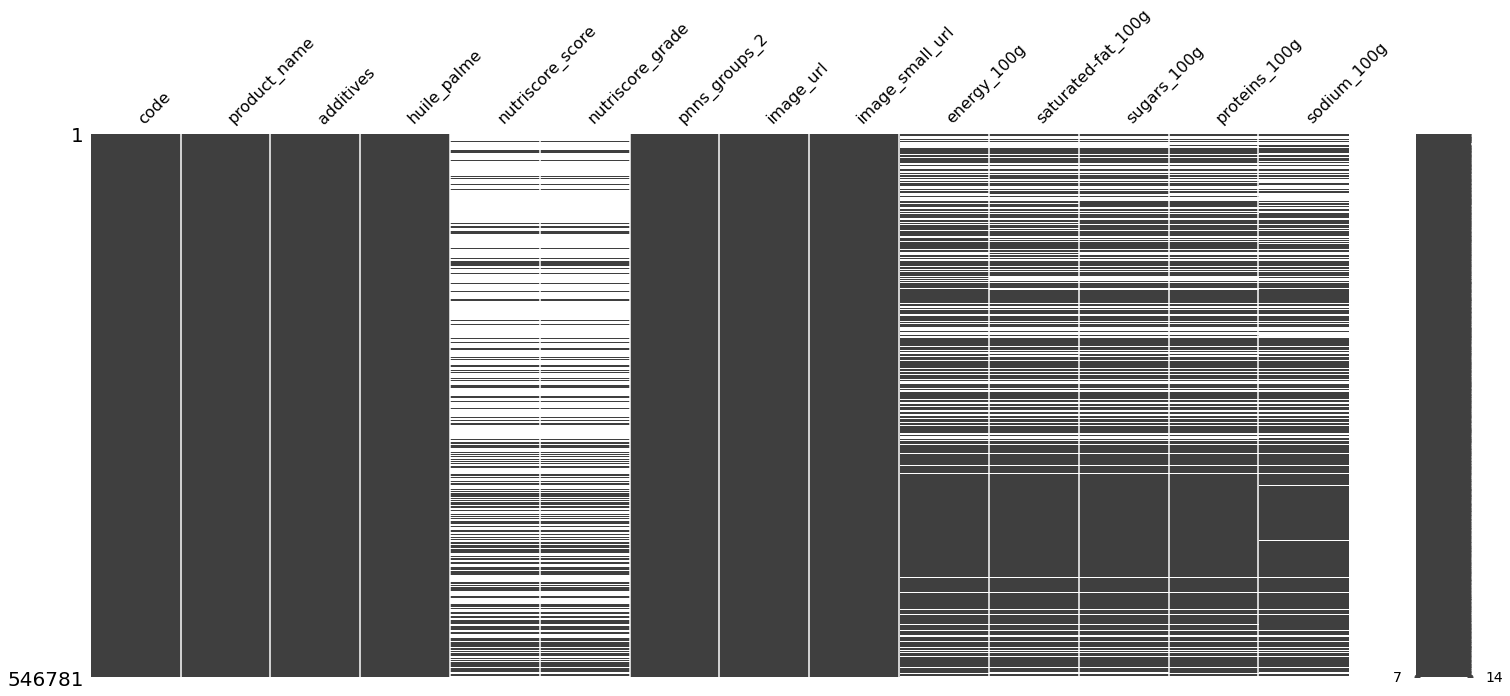

In [61]:
#Observons visuellement où sont nos valeurs manquantes dans notre jeu de données
msno.matrix(df_fr)

On supprime les boissons alcoolisées et les thés, herbes et cafés qui sont des produits qui n'ont pas de nutriscore.

In [62]:
exclus = ['Alcoholic beverages', 'Teas and herbal teas and coffees']

df_fr = df_fr[~df_fr['pnns_groups_2'].isin(exclus)]

Nous souhaitons supprimer les lignes qui ont beaucoup de valeurs nutritionnelles manquantes.  On regarde le nombre de ligne restant selon le nombre de valeurs manquantes par ligne.

In [63]:
df_dropped = df_fr[['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'sodium_100g']]

In [64]:
# Un threshold de 1 signifie que nous voulons au moins une valeur nutritionnelle dans notre ligne
for val in range(6):
    df_dropped.dropna(axis = 0, thresh = val, inplace = True)
    print("Avec un threshold de",val,"le dataframe aurait {} lignes".format(df_dropped.shape[0]))

Avec un threshold de 0 le dataframe aurait 538010 lignes
Avec un threshold de 1 le dataframe aurait 440855 lignes
Avec un threshold de 2 le dataframe aurait 432741 lignes
Avec un threshold de 3 le dataframe aurait 428880 lignes
Avec un threshold de 4 le dataframe aurait 427321 lignes
Avec un threshold de 5 le dataframe aurait 405805 lignes


On supprime les lignes qui ont plus de deux valeurs nutritionnelles manquantes.

In [65]:
df_fr.dropna(axis = 0, subset = ['energy_100g', 'saturated-fat_100g', 'sugars_100g',\
                               'proteins_100g', 'sodium_100g'], thresh = 3, inplace = True)

In [66]:
#On vérifie si on retrouve bien le bon nombre de lignes souhaité
df_fr.shape

(428880, 14)

Pour les colonnes se rapportant aux valeurs nutritionnelles, nous allons remplacer les valeurs manquantes par la valeur moyenne de chaque groupe de produit (les groupes étant affichés dans la colonne "pnns_groups_2".

In [67]:
colonnes = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'sodium_100g']

In [68]:
for col in colonnes:
    df_fr[col] = df_fr[col].fillna(df_fr.groupby('pnns_groups_2')[col].transform('mean'))

<AxesSubplot:>

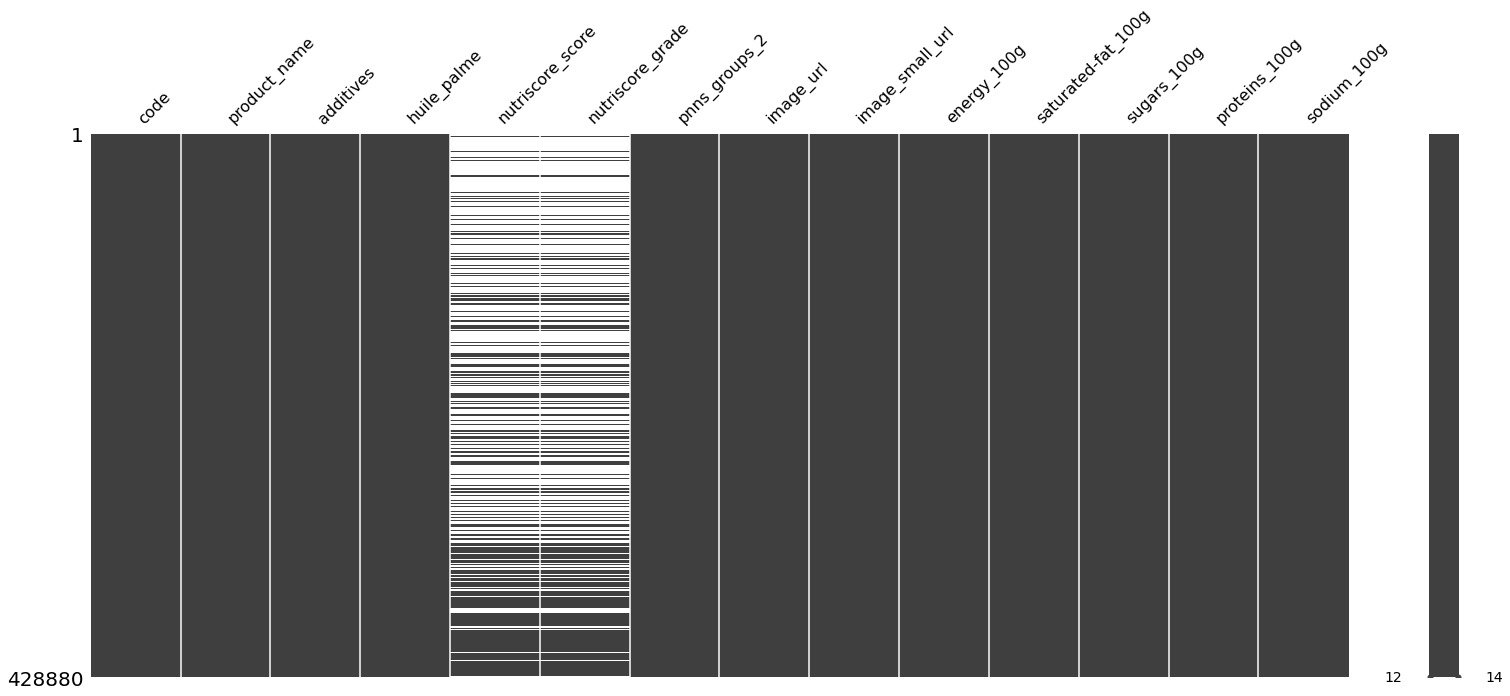

In [69]:
#Vérifions, il ne devrait plus y avoir de valeurs manquantes dans nos colonnes à l'exception de nos colonnes
# du nutriscore ("nutriscore_score" et "nutriscore_grade")
msno.matrix(df_fr)

Observons la distribution de "nutriscore_score" et "nutriscore_grade" avant notre imputation.

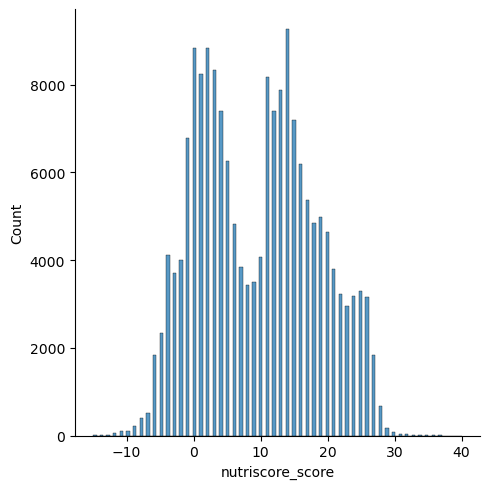

In [70]:
x = pd.Series(df_fr['nutriscore_score'], name = "nutriscore_score")

plt.style.use('default')
ax = sns.displot(x)

In [71]:
#On ordonne nos valeurs pour avoir nos notes de la meilleur à la moins bonne
df_fr.sort_values('nutriscore_grade', inplace = True)

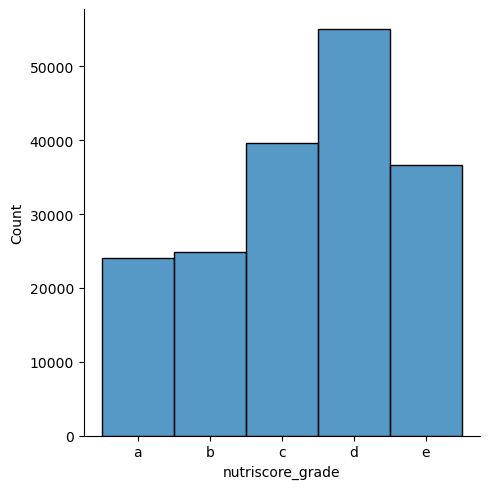

In [72]:
x = pd.Series(df_fr['nutriscore_grade'], name = "nutriscore_grade")

ax = sns.displot(x)

In [73]:
#On crée une copie de notre jeu de données qui va nous servir à vérifier que notre imputation
# de notre nutriscore_grade, après l'imputation de nutriscore_score, est bonne.
df_test = df_fr.copy()

Nous allons maintenant remplir la colonne "nutriscore_score" en utilisant un algorithme de Machine Learning : KNN Regressor. Nous allons regarder les k plus proches voisins de nos valeurs manquantes pour en déterminer la valeur. Ici, un voisin correspond à une ligne.

In [74]:
#Il ne doit pas y avoir de valeur manquantes dans les données de notre algorithme,
#on crée une copie et on supprime
df_ml = df_fr.copy()
df_ml = df_ml.dropna(subset = ['nutriscore_score'])

In [75]:
#On garde seulement les colonnes qui nous intéresse pour déterminer le nutriscore : les valeurs nutritionnelles.
df_ml = df_ml[['energy_100g', 'saturated-fat_100g', 'sugars_100g',\
               'proteins_100g', 'sodium_100g', 'nutriscore_score']]

In [76]:
#X : les données qui vont nous servir à déterminer notre nutriscore
#y : les données à déterminer (ici : le nutriscore)
X = df_ml.drop('nutriscore_score', axis = 1).values
y = df_ml['nutriscore_score'].values

In [77]:
#On divise notre DataFrame en deux : jeu d'entraînement (80% du jeu initial), jeu de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24, train_size = 0.8)

In [78]:
#On va devoir centrer et réduire nos données afin de pouvoir les utiliser
scaler = StandardScaler()

In [79]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [81]:
#On va tester notre KNN Regressor selon plusieurs paramètres :
# - le nombre de voisins,
# - la distance utilisée,
# - le type de pondération des plus proches voisins.

param_grid = {'n_neighbors': np.arange(1,9), 'metric': ['euclidean', 'manhattan', 'minkowski'],\
              'weights' : ['uniform', 'distance']}
knn_cv = GridSearchCV(KNeighborsRegressor(), param_grid, verbose = 1, cv = 5)
knn_cv.fit(X_train, y_train) 
print(knn_cv.best_params_, '\n')
print(knn_cv.best_estimator_, '\n')
print(knn_cv.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'} 

KNeighborsRegressor(metric='manhattan', n_neighbors=8, weights='distance') 

0.9081175652347888


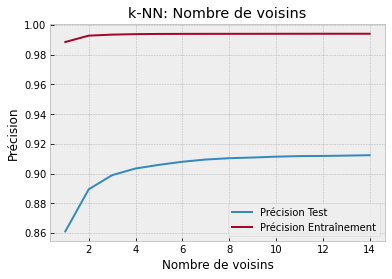

In [82]:
#On peut observer le résultat précédent graphiquement.
#On utilise la distance et la pondération déterminée précédemment.

plt.style.use('bmh')
neighbors = np.arange(1, 15)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsRegressor(n_neighbors = k, weights = 'distance', metric = 'manhattan')
    knn.fit(X_train,y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

plt.title('k-NN: Nombre de voisins')
plt.plot(neighbors, test_accuracy, label = 'Précision Test')
plt.plot(neighbors, train_accuracy, label = 'Précision Entraînement')
plt.legend()
plt.xlabel('Nombre de voisins')
plt.ylabel('Précision')
plt.show()

In [80]:
#Nous pouvons maintenant mettre en place notre modèle.
knn = KNeighborsRegressor(n_neighbors = 8, weights = 'distance', metric = 'manhattan')
knn.fit(X_train, y_train)

print("Score d'entraînement :", knn.score(X_train,y_train), ('\n'))
print("Score de test :", knn.score(X_test,y_test))

Score d'entraînement : 0.9940798928358177 

Score de test : 0.9104066063882505


In [81]:
#On calcule nos prédictions
y_pred = knn.predict(X_test)

Vérifions la distribution de nos prédictions sur le jeu de test :

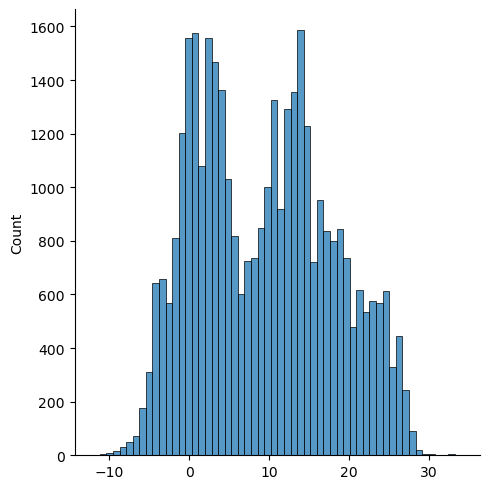

In [82]:
plt.style.use('default')
sns.displot(y_pred)

La forme est la même que celle du jeu de données principal, nous pouvons imputer nos valeurs manquantes de cette manière.

In [83]:
df_inter = df_fr.copy()

In [84]:
df_inter = df_inter[['energy_100g', 'saturated-fat_100g', 'sugars_100g',\
               'proteins_100g', 'sodium_100g', 'nutriscore_score']]

In [85]:
df_inter.dropna(subset = ['energy_100g'], inplace = True)

In [86]:
X = df_inter.drop('nutriscore_score', axis = 1).values
X_scaled = scaler.transform(X)

y_pred_inter = knn.predict(X_scaled)

In [87]:
df_inter['inter'] = y_pred_inter

df_inter['nutriscore_score'] = df_inter['inter']

In [88]:
df_imputed = df_fr.copy()

In [89]:
#On remplace nos valeurs manquantes par les prédictions de notre modèle
df_imputed['nutriscore_score'].fillna(df_inter['nutriscore_score'], inplace = True)
df_imputed.dropna(subset = ['energy_100g'], inplace = True)

Nous allons maintenant remplir notre colonne "nutriscore_grade" grâce à la formule du Nutriscore. Il faut commencer par diviser nos produits en sous-groupes.

In [90]:
df_imputed['pnns_groups_2'].unique()

array(['Sweets', 'Dressings and sauces', 'Cereals', 'Nuts', 'Fruits',
       'Dried fruits', 'Vegetables', 'Legumes',
       'Plant-based milk substitutes', 'Fish and seafood',
       'Milk and yogurt', 'Breakfast cereals', 'Bread', 'Soups', 'Eggs',
       'One-dish meals', 'Cheese', 'unknown', 'Meat', 'Processed meat',
       'Biscuits and cakes', 'Dairy desserts', 'Salty and fatty products',
       'Waters and flavored waters', 'Pizza pies and quiches',
       'Sandwiches', 'Potatoes', 'Appetizers',
       'Artificially sweetened beverages', 'Fats', 'Offals',
       'Sweetened beverages', 'Chocolate products', 'Ice cream',
       'Pastries', 'Fruit juices', 'Unsweetened beverages',
       'Fruit nectars'], dtype=object)

In [91]:
#Le calcul du nutriscore dépend de la catégorie du produit (eau, boisson ou aliment solide)

eaux = ['Waters and flavored waters']

boissons = ['Sweetened beverages', 'Fruit juices', 'Unsweetened beverages',\
            'Artificially sweetened beverages', 'Fruit nectars']

aliments_solides = ['unknown', 'Dressings and sauces', 'One-dish meals', 'Biscuits and cakes',\
                    'Fruits', 'Meat', 'Cheese', 'Bread', 'Fish and seafood', 'Sweets',\
                    'Salty and fatty products', 'Dried fruits', 'Vegetables', 'Fats',\
                    'Dairy desserts', 'Milk and yogurt', 'Pastries', 'Pizza pies and quiches',\
                    'Legumes', 'Nuts', 'Cereals', 'Breakfast cereals',\
                    'Appetizers', 'Processed meat', 'Chocolate products', 'Eggs',\
                    'Plant-based milk substitutes', 'Sandwiches', 'Ice cream', 'Soups',\
                    'Potatoes', 'Offals', 'pastries', 'Pizza pies and quiche']


In [92]:
#On va ne remplacer que les valeurs manquantes. Nous ne touchons pas aux notes déjà présentes
df_grade_null = df_imputed[df_imputed['nutriscore_grade'].isnull()]

In [93]:
df_eaux = df_grade_null[df_grade_null['pnns_groups_2'].isin(eaux)]

df_boissons = df_grade_null[df_grade_null['pnns_groups_2'].isin(boissons)]

df_aliments = df_grade_null[df_grade_null['pnns_groups_2'].isin(aliments_solides)]

In [94]:
#On associe une note selon le score de chaque produit, selon la catégorie à laquelle il appartient.

grade_aliments = []
grade_boissons = []
grade_eaux = []

for value in df_aliments['nutriscore_score'].values:
    if value < 0:
        grade_aliments.append('a')
    elif (value >= 0) & (value < 2.5):
        grade_aliments.append('b')
    elif (value >= 2.5) & (value < 10.5):
        grade_aliments.append('c')
    elif (value >= 10.5) & (value <= 18):
        grade_aliments.append('d')
    else:
        grade_aliments.append('e')
        
for value in df_boissons['nutriscore_score'].values:
    if value <= 1:
        grade_boissons.append('b')
    elif (value > 1) & (value < 5.5):
        grade_boissons.append('c')
    elif (value >= 5.5) & (value <= 9):
        grade_boissons.append('d')
    else:
        grade_boissons.append('e')
        
for value in df_eaux['nutriscore_score'].values:
    grade_eaux.append('a')

In [95]:
df_aliments['nutriscore_grade'] = grade_aliments
df_boissons['nutriscore_grade'] = grade_boissons
df_eaux['nutriscore_grade'] = grade_eaux

In [96]:
for data in [df_aliments, df_boissons, df_eaux]:
    df_imputed['nutriscore_grade'].fillna(data['nutriscore_grade'], inplace = True)

<AxesSubplot:>

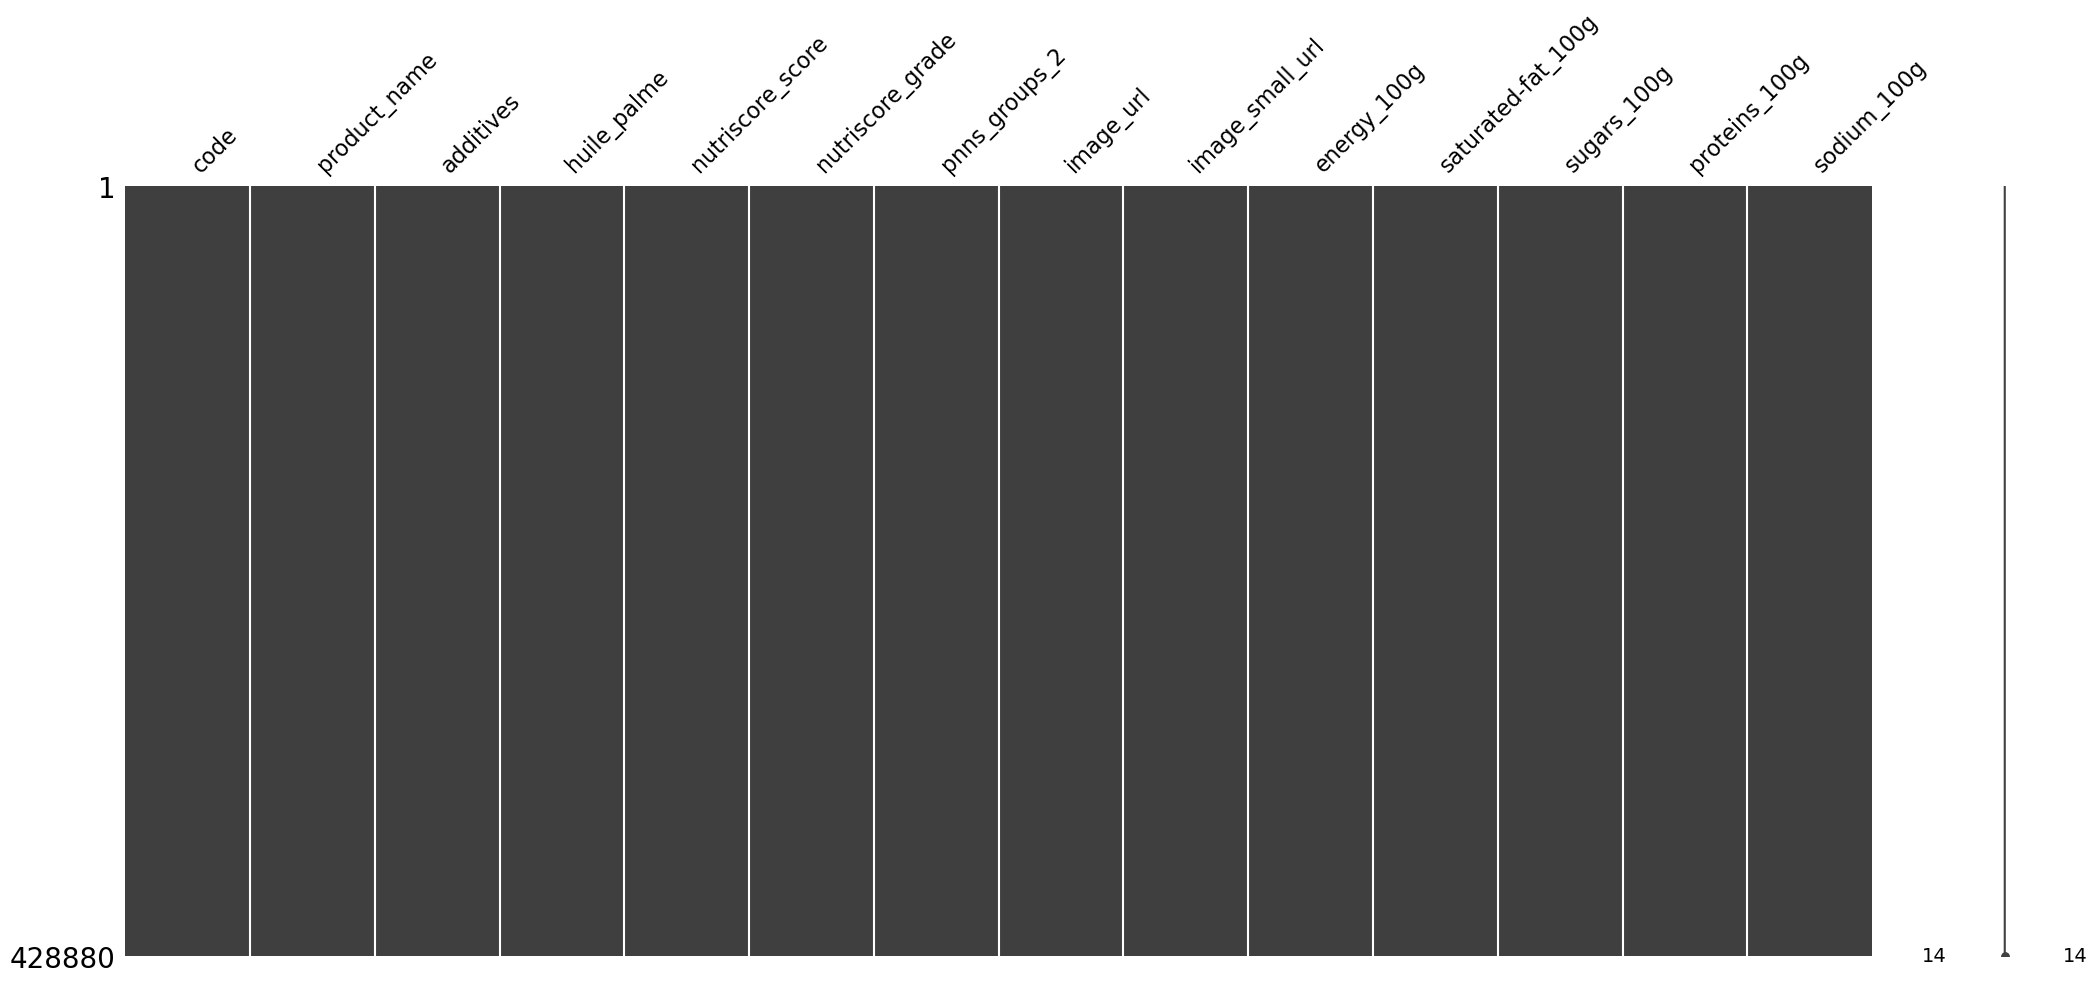

In [97]:
#Nous ne devrions plus avoir de valeurs manquantes
msno.matrix(df_imputed)

In [98]:
#On va tester notre formule du nutriscore_grade sur les valeurs déjà remplies, pour vérifier notre formule.
df_bis = df_imputed.copy()

In [99]:
df_eaux_bis = df_bis[df_bis['pnns_groups_2'].isin(eaux)]

df_boissons_bis = df_bis[df_bis['pnns_groups_2'].isin(boissons)]

df_aliments_bis = df_bis[df_bis['pnns_groups_2'].isin(aliments_solides)]

grade_aliments_bis = []
grade_boissons_bis = []
grade_eaux_bis = []

for value in df_aliments_bis['nutriscore_score'].values:
    if value < 0:
        grade_aliments_bis.append('a')
    elif (value >= 0) & (value < 2.5):
        grade_aliments_bis.append('b')
    elif (value >= 2.5) & (value < 10.5):
        grade_aliments_bis.append('c')
    elif (value >= 10.5) & (value <= 18):
        grade_aliments_bis.append('d')
    else:
        grade_aliments_bis.append('e')
        
for value in df_boissons_bis['nutriscore_score'].values:
    if value <= 1:
        grade_boissons_bis.append('b')
    elif (value > 1) & (value < 5.5):
        grade_boissons_bis.append('c')
    elif (value >= 5.5) & (value <= 9):
        grade_boissons_bis.append('d')
    else:
        grade_boissons_bis.append('e')
        
for value in df_eaux_bis['nutriscore_score'].values:
    grade_eaux_bis.append('a')

In [100]:
df_aliments_bis['nutriscore_grade'] = grade_aliments_bis
df_boissons_bis['nutriscore_grade'] = grade_boissons_bis
df_eaux_bis['nutriscore_grade'] = grade_eaux_bis

nutriscore_grade = grade_aliments_bis + grade_boissons_bis + grade_eaux_bis

df_bis['nutriscore_grade_test'] = nutriscore_grade

In [101]:
#On met nos valeurs sous forme de liste pour les comparer
bis = df_bis['nutriscore_grade'].tolist()
test = df_bis['nutriscore_grade_test'].tolist()

In [102]:
if(set(bis) == set(test)):
    print("Les listes sont les mêmes")
else:
    print("Les listes sont différentes")

Les listes sont les mêmes


On peut vérifier ce résultat en calculant la corrélation entre nos anciennes valeurs et ces mêmes valeurs si nous utilisions notre formule de calcul du nutriscore_grade.

In [103]:
#On commence par ne garder que les lignes qui avaient une note au départ.
df_grade_test = df_test.dropna(subset = ['nutriscore_grade'])

df_bis = df_bis[df_bis.index.isin(df_grade_test.index)]

#Pour calculer une matrice de corrélation, nous avons besoin de valeurs numériques.
df_grade_test['nutriscore_grade_distrib'] = \
df_grade_test['nutriscore_grade'].replace(['a', 'b', 'c', 'd', 'e'], [1 ,2 ,3 ,4 ,5])

df_bis['nutriscore_grade_distrib'] = \
df_bis['nutriscore_grade'].replace(['a', 'b', 'c', 'd', 'e'], [1 ,2 ,3 ,4 ,5])

In [104]:
df_bis['nutriscore_grade_test'] = df_grade_test['nutriscore_grade_distrib']

df_bis[['nutriscore_grade_test', 'nutriscore_grade_distrib']].corr()

,nutriscore_grade_test,nutriscore_grade_distrib
nutriscore_grade_test,1.0,1.0
nutriscore_grade_distrib,1.0,1.0


Vérifions la distribution de notre nutriscore_score et nutriscore_grade après notre imputation :

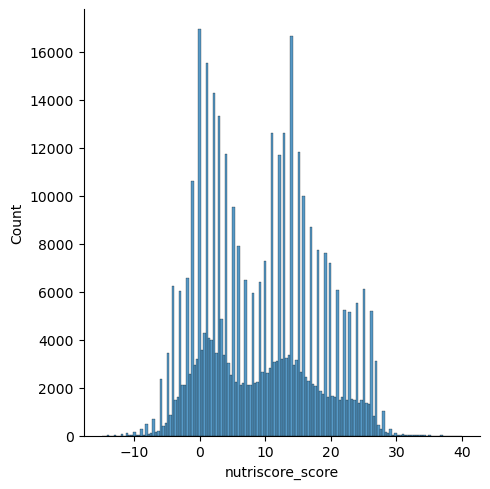

In [105]:
x = pd.Series(df_imputed['nutriscore_score'], name = "nutriscore_score")

ax = sns.displot(x)

In [106]:
#On ordonne nos valeurs pour avoir nos notes de la meilleur à la moins bonne
df_imputed.sort_values('nutriscore_grade', inplace = True)

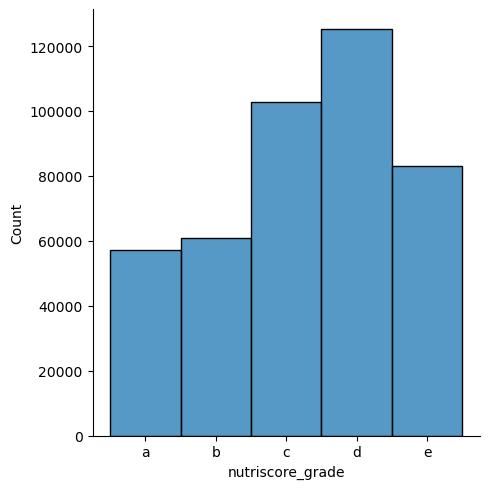

In [107]:
x = pd.Series(df_imputed['nutriscore_grade'], name = "nutriscore_grade")

ax = sns.displot(x)

In [108]:
#On vérifie qu'il n'y a plus de valeurs manquantes
df_imputed.isnull().sum()

code                  0
product_name          0
additives             0
huile_palme           0
nutriscore_score      0
nutriscore_grade      0
pnns_groups_2         0
image_url             0
image_small_url       0
energy_100g           0
saturated-fat_100g    0
sugars_100g           0
proteins_100g         0
sodium_100g           0
dtype: int64

In [109]:
#On sauvegarde notre jeu de données au format .csv
data_imputed = df_imputed.to_csv('data_to_analyze.csv')